In [1]:
!pip install lmfit
#!pip install seaborn

     |████████████████████████████████| 266kB 4.3MB/s 
     |████████████████████████████████| 215kB 10.9MB/s 
     |████████████████████████████████| 256kB 13.5MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.1-cp36-none-any.whl size=81991 sha256=976011cdc917e9dd44bbbb56d5435d8b423b24ea4acac5d3079df201a0f21120
  Stored in directory: /root/.cache/pip/wheels/ef/22/8d/6cd9c0af36f501cfb248673b05dad5d2c27504951d55519acb
  Created wheel for asteval: filename=asteval-0.9.19-cp36-none-any.whl size=17486 sha256=8c529b34480b4badc1649118dc3e8e30645f899815ac08abd26556908db6cbc0
  Stored in directory: /root/.cache/pip/wheels/59/da/bf/62853db4291f1c5f91326e32e4d1766b8cfcccd1c0e6eaf53f
Successfully built lmfit asteval


In [2]:
import numpy as np
#import cv2
import os
import re
import glob
import matplotlib.pyplot as plt
from scipy.signal import  gaussian
from scipy.ndimage import filters
from scipy import optimize
from scipy.stats import linregress
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import scipy as sp
import scipy.interpolate
from scipy.integrate import trapz

import time

import pandas as pd

from lmfit import Model, fit_report, Parameters

#from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


######### initialize the data ###############
data_input=[]
data_output=[]
l_sample=300
vol_all=[]
vol2_all=[]
data_x=[]
data_y=[]
data_h=[]
data_w=[]
R_sph_all=[]
Ar=[]
#st_all=[]
rho=[]
theta=[]
#List of non-processed images:
discarded=[]
new=[]  #list of images without the discarded ones

#For the simple approach fit
phi_final=[]
theta_az=[]
theta_all=[]
theta_final=[]
r_theta_all=[]
xc_all=[]
yc_all=[]
rho_final=[]
data_Ps=[]
data_dB=[]
data_stderr=[]
data_err=[]

total_num_pictures = len(glob.glob1('.',"*.png"))
frame_number=np.arange(total_num_pictures)

gamma=64 #[N/m]
Cg_air=1/101325 #Pa**(-1)
k_o=2*np.pi*40/340  #wave number in the air. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=340 m/s from paper (331.5 for 20oC online) 
#Calibration
needle_d=0.83 #mm
needle_pxl=220 #pixels
#calibration=0.00621722846441948**3
cal=needle_d/needle_pxl
calibration=(cal)**3


###############################################################################
#### Functions used in the data processing ####################################
###############################################################################

def calc_volume(x,y):
    """
    Calculate the drop volume from a shape matrix.

    Parameters
    ----------
    x, y - contour of the drop

    Returns
    -------
    Integrated volume using for the given shape matrix.

    """
    # data selection
    idx=x<=0  # r=right
    x_l=x[idx]
    y_l=y[idx]
        
    vol_left=trapz(np.pi*x_l**2, y_l)/2
        
    # data selection
    idx=x>=0  # r=right
    x_r=x[idx]
    y_r=y[idx]
    vol_right=-trapz(np.pi*x_r**2, y_r)/2
   
    return vol_left+vol_right


def calc_R_sph(vol, cal):
    """
    Calculate the spherical radius of a droplet based on the volume.

    Input parameters
    ----------
    vol:         volume   [pixels**3]
    calibration: calibration factor  [mm**3/pixels**3]

    Returns
    -------
    Corresponding spherical radius.  [mm]

    """
#    calibration=0.00621722846441948**3
    #R_sph=(3*vol*calibration/(4*np.pi))**(1/3)
    R_sph=(3*vol/(4*np.pi))**(1/3)
    return R_sph

def calc_dB(Ps):
    """
    Calculate the deci Bell (dB) value for each acoustic pressure Ps.

    Input parameters
    ----------
    Ps:     aplitude of the acoustic pressure

    Returns
    -------
    dB value. []

    """
    Po=2*10**(-5) #[Pa]

    return 20*np.log10(Ps/Po)     #Acoustic pressure [Pa]

def model_fit(th, Ps):
    """
    Express the model that will be used to fit the experimental data (simple approach).

    Input parameters
    ----------
    dB:     deciBell
    th:     angle theta
    Returns
    -------
    Expression of fitting model.

    """
#    Ps=calc_ampl(dB)
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))
    return ct_new*(3*(np.cos(th))**2-1)+R_sph


def R_predict(th, gamma, R_sph, Ps, Cg_air, k_o):
    """
    Prediction of ST. 
    After the acoustic pressure is determined. The ST is calculated based on the equation of our model. 
    
    
    Input parameters
    ----------
    th:     angle theta
    gamma:  ST as initial predition [mN/m]
    Power:  U*I [Watt]
    Returns
    -------
    gamma:   predicted surface tension [mN/m]

    """    
#    Ps=data_Ps[i-1]    #[Pa]
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)
    return ct_new+R_sph

def ST_predict(th, gamma, R_sph, Ps, Cg_air, k_o):
    """
    Prediction of ST. 
    After the acoustic pressure is determined. The ST is calculated based on the equation of our model. 
    
    
    Input parameters
    ----------
    th:     angle theta
    gamma:  ST as initial predition [mN/m]
    Power:  U*I [Watt]
    Returns
    -------
    gamma:   predicted surface tension [mN/m]

    """    
#    Ps=data_Ps[i-1]    #[Pa]
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)
    return ct_new+R_sph


def azimuth(phi):
    """
    Calculate the azimuthal angle.

    Input parameters
    ----------
    phi:     angle phi

    Returns
    -------
    Azimuthal angle.

    """

    if phi<=np.pi/2:
        a=np.pi/2-phi
    else:
        a=2.5*np.pi-phi
    return a


def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return(theta, rho)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


def pol2cart_theta(rho, theta):
    x = rho * np.sin(theta)
    y = rho * np.cos(theta)
    return(x, y)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.3.0
Num GPUs Available:  0


Generate random angle:
20 000 sets of 200 points

Radius in mm:  1.0607844179470554
(20000, 200)
(0, 200)
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500


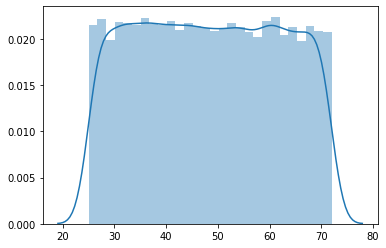

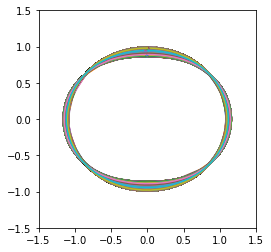

In [448]:
def gen_data(num_sample,sampling):

    np.random.seed(1234)

    #test=np.arange(100)
    #test_r=np.random.choice(test,10)

    vol_drop=5 # in µL
    calibration=0.0060567117466506235e-3 #mm/pixel
  
    #gamma=72.8 #[mN/m]   
    Cg_air=1/101325 #Pa**(-1)
    k_o=2*np.pi*40/340  #wave number in the air in [mm^-1]. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=340 m/s from paper (331.5 for 20oC online) 
    #Calibration
    Ps= 1600  #[Pa]
    R_sph=calc_R_sph(vol_drop, calibration)

    print("Radius in mm: ", R_sph)
    
    #num_sample=200  #ST
    #sampling=200

    #theta=np.linspace(0,2*np.pi, 100)

    #theta=np.random.random(200)*2*np.pi
    theta=np.random.rand(num_sample, sampling)*np.pi
    theta.sort()
    ST_range=np.random.random(num_sample)*(72-25)+25
    print(theta.shape)
    r_all=np.empty([0,sampling])
    print(r_all.shape)

    for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph, Ps, Cg_air, k_o)
          #print(r.shape)
         #print(r)
        r_all=np.vstack((r_all, r))
        
        if i % 100 == 0:
                print(i)
        

    print(r_all.shape)

    dataset=np.hstack((theta,r_all, ST_range.reshape([num_sample,1])))
    print(dataset.shape)

    #print(ST_range)
    print(ST_range.min())
    print(ST_range.max())
    #sns.set(color_codes=True)
    sns.distplot(ST_range);

    fig3 = plt.figure()
    ax = plt.gca()
    ax.set_aspect(1)
    ax.set_xlim([-1.5,1.5])
    ax.set_ylim([-1.5,1.5])
    

    for j in dataset:

      x,y=pol2cart_theta(j[sampling:sampling+sampling], j[0:sampling])
    #  print(x.shape)
    #  print(y.shape)

      #plt.plot(x*1e3,y*1e3)
      plt.plot(x,y)

    plt.show()
    return dataset

num_sample=20000  # number of different ST values
sampling=200 # number of coordiante point describing the contour


dataset=gen_data(num_sample,sampling)


column_names=[]
for i in range(sampling):
  column_names.append('theta')
for i in range(sampling):
  column_names.append('rho')

column_names.append('ST')


raw_dataset = pd.DataFrame(dataset, columns=column_names)

raw_dataset.to_csv('./dataset.csv',index=False)


In [ ]:

#input = pd.read_csv(io.BytesIO(uploaded['data.csv']))
#input = pd.DataFrame(dataset)
# Dataset is now stored in a Pandas Dataframe
#input.size


In [449]:
# loading of data

raw_dataset=pd.read_csv('dataset.csv')

dataset = raw_dataset.copy()
dataset.tail()

,theta,theta.1,theta.2,theta.3,theta.4,theta.5,theta.6,theta.7,theta.8,theta.9,theta.10,theta.11,theta.12,theta.13,theta.14,theta.15,theta.16,theta.17,theta.18,theta.19,theta.20,theta.21,theta.22,theta.23,theta.24,theta.25,theta.26,theta.27,theta.28,theta.29,theta.30,theta.31,theta.32,theta.33,theta.34,theta.35,theta.36,theta.37,theta.38,theta.39,...,rho.161,rho.162,rho.163,rho.164,rho.165,rho.166,rho.167,rho.168,rho.169,rho.170,rho.171,rho.172,rho.173,rho.174,rho.175,rho.176,rho.177,rho.178,rho.179,rho.180,rho.181,rho.182,rho.183,rho.184,rho.185,rho.186,rho.187,rho.188,rho.189,rho.190,rho.191,rho.192,rho.193,rho.194,rho.195,rho.196,rho.197,rho.198,rho.199,ST
19995,0.009773,0.011303,0.060575,0.112293,0.123772,0.130527,0.141380,0.167260,0.202962,0.206363,0.210331,0.229384,0.258612,0.274328,0.295451,0.297748,0.361605,0.366617,0.442028,0.451040,0.511785,0.513481,0.576186,0.667201,0.679674,0.690010,0.742281,0.759252,0.823595,0.827372,0.844896,0.873778,0.894318,0.940369,0.948158,0.957746,0.959934,0.989109,0.998219,1.076695,...,1.133165,1.133079,1.128532,1.125105,1.122654,1.121206,1.117477,1.102198,1.100858,1.086840,1.083017,1.079155,1.066345,1.043342,1.041554,1.040272,1.037059,1.015105,1.002569,1.002302,0.993695,0.972871,0.965827,0.962806,0.960118,0.950018,0.945370,0.925223,0.925158,0.921584,0.920934,0.919572,0.915609,0.910934,0.908708,0.907123,0.907061,0.907053,0.907027,32.252223
19996,0.008965,0.042472,0.043273,0.064577,0.082400,0.088693,0.116575,0.135483,0.177168,0.193012,0.218251,0.240488,0.290631,0.310191,0.365915,0.373478,0.408482,0.419900,0.461810,0.483980,0.509719,0.526536,0.542885,0.551989,0.634505,0.654260,0.681656,0.764426,0.777240,0.804237,0.891655,0.892687,0.945483,0.955518,1.002029,1.005053,1.039336,1.042929,1.088171,1.130464,...,1.145825,1.145786,1.145017,1.144768,1.144367,1.143182,1.139511,1.136575,1.131950,1.129705,1.129513,1.120801,1.094105,1.093181,1.091418,1.083482,1.076732,1.069873,1.066525,1.049136,1.046936,1.042977,1.020291,1.012293,0.969717,0.968929,0.966005,0.965863,0.954827,0.935336,0.913833,0.913824,0.901588,0.901246,0.900742,0.894169,0.893890,0.892595,0.890728,29.147202
19997,0.034328,0.074429,0.098381,0.107143,0.122114,0.129121,0.137911,0.143670,0.159492,0.176554,0.189311,0.241693,0.253761,0.258997,0.277908,0.351971,0.362318,0.370591,0.408116,0.408428,0.413513,0.445829,0.470964,0.486273,0.534163,0.581937,0.640716,0.661362,0.668757,0.749181,0.769756,0.783343,0.809923,0.841109,0.921916,0.931332,0.949643,1.134579,1.183396,1.203556,...,1.096839,1.096792,1.096572,1.096289,1.096139,1.095993,1.090807,1.087040,1.084587,1.084221,1.080732,1.074719,1.071880,1.070774,1.067521,1.061375,1.059986,1.058479,1.056929,1.051657,1.047913,1.042147,1.039088,1.028305,1.025404,1.012564,1.004964,1.003537,0.997321,0.996377,0.994524,0.994361,0.994175,0.993946,0.992289,0.989851,0.989469,0.989203,0.988622,68.727341
19998,0.045656,0.050916,0.109330,0.146726,0.210851,0.243398,0.334508,0.384158,0.412512,0.412514,0.418850,0.581158,0.582752,0.584539,0.613947,0.661779,0.670049,0.690219,0.693292,0.717104,0.727213,0.750770,0.756144,0.804111,0.871723,0.898818,0.965504,0.999707,1.022200,1.032955,1.046904,1.063057,1.102367,1.176759,1.188942,1.218295,1.250971,1.291633,1.305236,1.332238,...,1.073209,1.070135,1.068132,1.065741,1.064251,1.048984,1.045757,1.038985,1.037319,1.031061,1.031058,1.026881,1.022839,1.022739,1.020175,1.019131,1.012708,1.010230,1.008688,1.007309,1.006447,1.002532,1.001886,1.001774,0.999060,0.992709,0.985097,0.983136,0.983051,0.982470,0.982357,0.981582,0.980881,0.980537,0.980130,0.980038,0.980008,0.979958,0.979956,61.359736
19999,0.009613,0.094927,0.095200,0.102870,0.166819,0.166943,0.198911,0.228884,0.237084,0.309890,0.319283,0.346297,0.373366,0.394301,0.414239,0.474029,0.478463,0.510046,0.515853,0.591117,0.665938,0.733739,0.768377,0.823760,0.888340,0.966166,1.001383,1.036227,1.043397,1.070165,1.114728,1.134956,1.205168,1.285077,1.323993,1.325175,1.387341,1.403474,1.415550,1.420244,...,1.093431,1.090879,1.085871,1.070135,1.

### Adding noise to the data

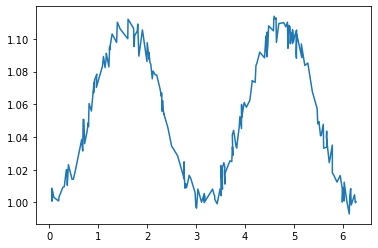

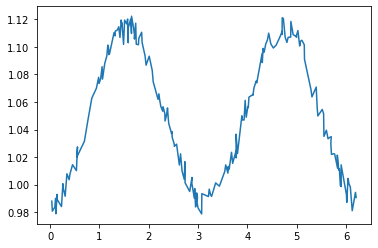

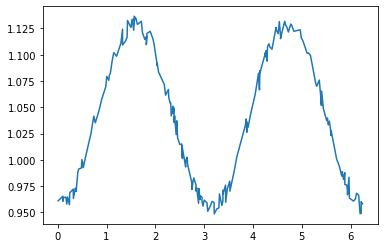

In [402]:
#tf.random.set_seed(5);
#Gaussian_noise=tf.random.normal(shape=[dataset.shape], mean=0, stddev=1, dtype=tf.dtypes.float64)

#dataset_Gauss=dataset+Gaussian_noise
#plt.figure()
##plt.plot(Gaussian_noise[:, 2])
#min(Gaussian_noise.all())
#max(Gaussian_noise.all())
np.random.seed(seed=1)
noise = np.random.random(size=dataset.shape)*0.02
#print(noise)
dataset=dataset+noise
#dataset_noise[0, 0:200]
plt.figure()
plt.plot(dataset.iloc[0, 0:200], dataset.iloc[0, 200:400])
plt.figure()
plt.plot(dataset.iloc[10000, 0:200], dataset.iloc[10000, 200:400])
plt.figure()
plt.plot(dataset.iloc[19999, 0:200], dataset.iloc[19999, 200:400])


### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [450]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

In [ ]:
#sns.pairplot(train_dataset[column_names], diag_kind="kde")
#plt.show()

Also look at the overall statistics:

In [451]:
train_stats = train_dataset.describe()
train_stats.pop("ST")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
theta,16000.0,0.030700,0.030591,0.000003,0.008670,0.021488,0.042749,0.278093
theta.1,16000.0,0.061864,0.043499,0.000164,0.029862,0.052142,0.083295,0.398188
theta.2,16000.0,0.092940,0.052926,0.002495,0.054136,0.083860,0.120996,0.489584
theta.3,16000.0,0.124585,0.060997,0.006154,0.079756,0.114804,0.158804,0.492807
theta.4,16000.0,0.155845,0.068403,0.014900,0.105702,0.146161,0.194878,0.590842
...,...,...,...,...,...,...,...,...
rho.195,16000.0,0.953643,0.033561,0.863747,0.931150,0.962429,0.981675,1.021681
rho.196,16000.0,0.952059,0.033907,0.862904,0.929177,0.960999,0.980522,1.014271
rho.197,16000.0,0.950768,0.034213,0.862765,0.927689,0.959743,0.979575,1.003073
rho.198,16000.0,0.949815,0.034446,0.862614,0.926494,0.958809,0.978950,1.000251


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [452]:
train_labels = train_dataset.pop('ST')
test_labels = test_dataset.pop('ST')

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [453]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

###Learning Schedule
The code bellow sets a schedules.InverseTimeDecay to hyperbolically decrease the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 epochs and so on.

In [454]:
#Lr_schedule = learning schedule : Most models learn better if you gradually decrase the learning rate.

STEPS_PER_EPOCH=len(train_dataset)/500
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

Here we can plot the learning rate Vs the number of epocs

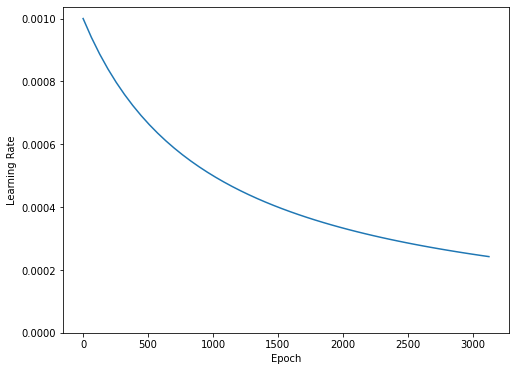

In [455]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [456]:
def build_model():
  model = keras.Sequential([
    #layers.Dense(100, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(14, activation=tf.nn.swish, input_shape=[len(train_dataset.keys())]),
    #layers.Dense(50, activation=tf.nn.swish),
    layers.Dense(5, activation=tf.nn.swish),
    layers.Dense(1)
  ])

  optimizer = get_optimizer() # tf.keras.optimizers.Adam(learning_rate=0.001) #RMSprop(0.0001)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [480]:
model = build_model()

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [458]:
model.summary()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_145 (Dense)            (None, 14)                5614      
_________________________________________________________________
dense_146 (Dense)            (None, 5)                 75        
_________________________________________________________________
dense_147 (Dense)            (None, 1)                 6         
Total params: 5,695
Trainable params: 5,695
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [459]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 1.4783881 ],
       [ 0.04202371],
       [ 0.46618506],
       [-0.11094198],
       [ 0.11034737],
       [ 0.35821182],
       [-0.18164915],
       [-0.5072448 ],
       [ 0.12149434],
       [-0.16098142]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [481]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])



....................................................................................................
................................................................................

Visualize the model's training progress using the stats stored in the `history` object.

In [482]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail() 

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
175,0.080639,0.220541,0.080639,0.122573,0.265303,0.122573,175
176,0.079103,0.216615,0.079103,0.139566,0.274682,0.139566,176
177,0.076995,0.213764,0.076995,0.099366,0.238764,0.099366,177
178,0.077814,0.215909,0.077814,0.133640,0.269282,0.133640,178
179,0.078893,0.216294,0.078893,0.110607,0.243672,0.110607,179


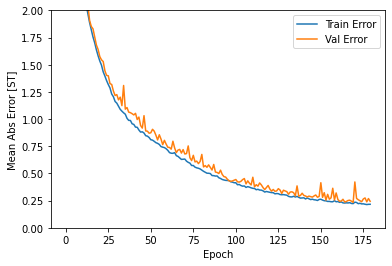

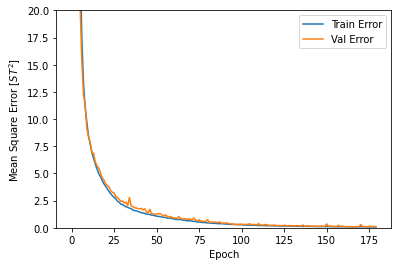

In [483]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ST]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ST^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [484]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} mN/m".format(mae))

Testing set Mean Abs Error:  0.24 mN/m


### Make predictions

Finally, predict volt values using data in the testing set:

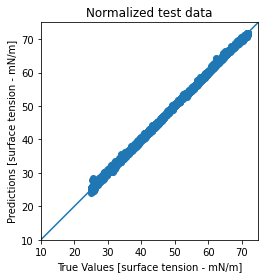

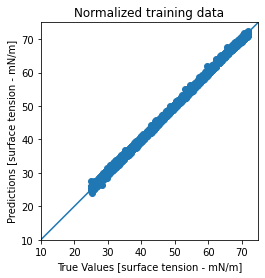

In [485]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.title('Normalized test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

test_predictions2 = model.predict(normed_train_data).flatten()

plt.scatter(train_labels, test_predictions2)
plt.title('Normalized training data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


Seriously?

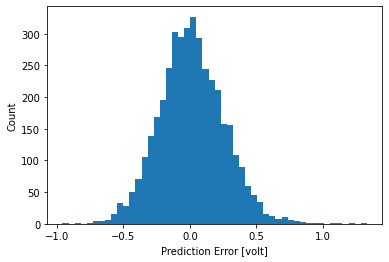

In [472]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [volt]")
_ = plt.ylabel("Count")
plt.show()

# Saving the final Model

When you are satisfied with the model and the accuracy continue from here:

Run the next code box only if google drive is not mounted to colab

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Saving the model in a **SavedModel** format

In [ ]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import os

In [473]:
# Save the entire model as a SavedModel.
filename=str('test_training_whole_drop_best.h5')
!mkdir -p '/content/drive/My Drive/DropLev/MachineLearningModels' #Ceates a folder named "MachineLearningModels"
model.save('/content/drive/My Drive/DropLev/MachineLearningModels/'+filename)  #Saves the file

# Reload a fresh Keras model from the saved model:

For **SavedModel** format

In [399]:
new_model = tf.keras.models.load_model('/content/drive/My Drive/DropLev/MachineLearningModels/'+filename)

# Check its architecture
new_model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_127 (Dense)            (None, 20)                8020      
_________________________________________________________________
dense_128 (Dense)            (None, 50)                1050      
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 51        
Total params: 9,121
Trainable params: 9,121
Non-trainable params: 0
_________________________________________________________________


Evaluate the restored model:

In [322]:
# Evaluation
loss, mae, mse = new_model.evaluate(normed_test_data, test_labels, verbose=0)
print('Restored model, Mean absolute error: {:5.2f}'.format(mae))

print(new_model.predict(normed_test_data).shape)

Restored model, Mean absolute error:  0.48
(4000, 1)
